In [1]:
import math
import os
import site
import sqlite3
import sys
from time import sleep

import logzero
import numpy as np
import pandas as pd
import yaml
from logzero import logger
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import SARIMAX, VAR, acf, adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.tools import diff
from tqdm import tqdm_notebook as tqdm
from yaml import dump, load, safe_load

In [2]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
sys.path.append("../../sql")
import queries

sys.path.append("../source")
import plot_tools
import ts_tools

In [4]:
import warnings

warnings.filterwarnings("ignore")

In [5]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = 30, 25
plt.rcParams["ytick.labelsize"] = 11
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelpad"] = 12
plt.rcParams["axes.xmargin"] = 0.01
plt.rcParams["axes.ymargin"] = 0.01

In [6]:
log_path = "logs/"
log_file = "ts_arima.log"

logzero.logfile(log_path + log_file, maxBytes=1e6, backupCount=5, disableStderrLogger=True)
logger.info(f"{log_path}, {log_file}\n")

In [7]:
configs = None
try:
    with open("../configs/config.yml", "r") as config_in:
        configs = load(config_in, Loader=yaml.SafeLoader)
        logger.info(f"{configs}\n")
except:
    logger.error(f"config file open failure.")
    exit(1)

cfg_vars = configs["url_variables"]
logger.info(f"variables: {cfg_vars}\n")

years = configs["request_years"]
logger.info(f"years: {years}\n")

db_path = configs["file_paths"]["db_path"]

city = configs["location_info"]["city"]
state = configs["location_info"]["state"]
db_file = city + "_" + state + ".db"

db_table1 = configs["table_names"]["db_table1"]
db_table2 = configs["table_names"]["db_table2"]

logger.info(f"{db_path}, {db_file}")

nrows = configs["num_rows"][0]
logger.info(f"number of rows: {nrows}\n")

In [8]:
conn = sqlite3.connect(db_path + db_file)
cursor = conn.cursor()

In [9]:
cursor.execute(queries.select_distinct_zips)
distinct_zipcodes = cursor.fetchall()
distinct_zipcodes = [z[0] for z in distinct_zipcodes]
logger.info(f"distinct zip codes:\n{distinct_zipcodes}")
print(distinct_zipcodes)

['10514', '12309', '14031', '14534', '14817', '32312', '32317', '32424', '32605', '32606', '32653', '32803', '32828', '32927', '53005', '53092', '53217', '53597', '53719', '75022', '75035', '76904', '77059', '77062', '78002', '78039', '78504', '78733', '85045', '85253', '85286', '85747', '86032', '90272', '91011', '94024', '94127', '95973', '98029', '98177', '98607', '99337', '99338']


In [10]:
zipcode_index = 0

df = ts_tools.get_irr_data(
    conn,
    distinct_zipcodes[zipcode_index],
)
# df.head(5)

In [11]:
columns = df.columns.tolist()
feature_units = ["Wh", "Wh", "Wh", "Wh", "°C", "%RH", "mm", "m/hr"]

In [12]:
df[["Clearsky_DNI", "DNI", "Clearsky_GHI", "GHI"]][
    (df["Clearsky_DNI"] > 0.0) & (df["Clearsky_GHI"] > 0.0)
].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Clearsky_DNI,99606.0,638.662460,233.950183,1.0,505.0,700.0,820.0,1034.0
DNI,99606.0,379.783035,336.974780,0.0,22.0,326.0,713.0,1034.0
Clearsky_GHI,99606.0,463.120324,275.046064,1.0,236.0,452.0,693.0,1020.0
GHI,99606.0,342.833675,267.638652,0.0,108.0,284.0,538.0,1020.0


In [13]:
df[["Temperature", "Relative_Humidity", "Precipitable_Water", "Wind_Speed"]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Temperature,201624.0,10.039525,10.144781,-23.000,1.000,10.000,18.300,38.000
Relative_Humidity,201624.0,81.481517,17.932796,21.810,69.040,86.100,98.470,100.000
Precipitable_Water,201624.0,1.941077,1.266307,0.085,0.862,1.684,2.804,6.611
Wind_Speed,201624.0,1.552402,0.816087,0.000,1.000,1.400,1.900,8.000


In [14]:
df_rsm = df.resample("M").mean().reset_index(drop=False)
df_rsm.set_index("date_time", inplace=True)
# df_rsm

In [15]:
df_rsm.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Clearsky_DNI,276.0,315.486642,49.645539,214.857527,278.910966,322.111031,354.950269,422.787634
DNI,276.0,187.619563,44.331841,51.548387,154.766815,187.146937,220.895833,292.734722
Clearsky_GHI,276.0,228.563792,84.506337,98.262097,154.738721,237.717361,302.287198,348.920833
GHI,276.0,169.168461,69.365322,36.708333,97.828269,173.149194,229.172043,291.922222
Temperature,276.0,9.983032,8.989155,-8.561012,1.164706,9.788956,18.751910,25.098925
Relative_Humidity,276.0,81.489122,5.047615,62.012675,78.728797,82.265459,85.129348,91.174462
Precipitable_Water,276.0,1.935250,0.926202,0.632522,1.121169,1.660970,2.782501,4.080181
Wind_Speed,276.0,1.555054,0.338611,0.962769,1.282268,1.505376,1.794450,2.518683


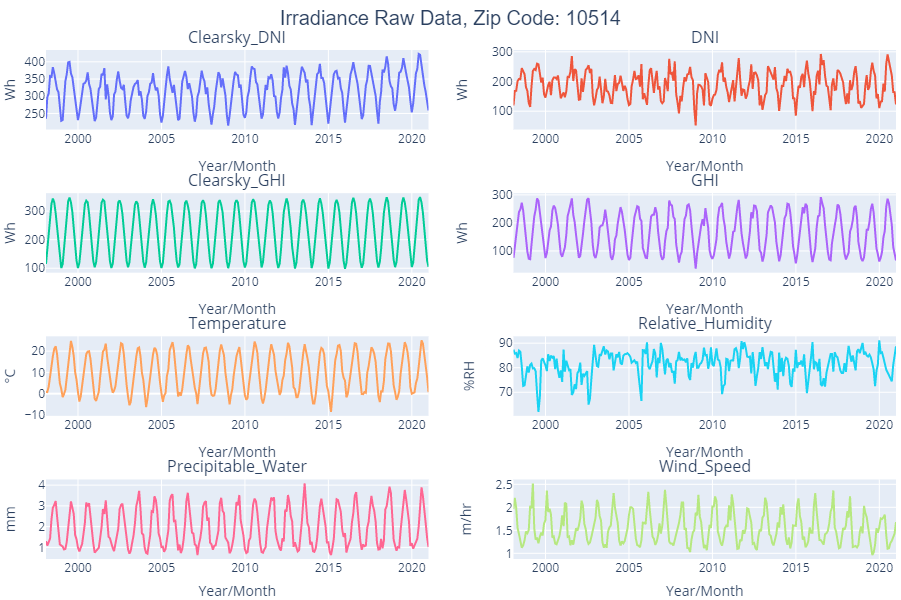

In [23]:
title = "Irradiance Raw Data"
plot_tools.plot_data(
    df_rsm,
    title=title,
    zipcode=distinct_zipcodes[zipcode_index],
    columns=columns,
    feature_units=feature_units,
)

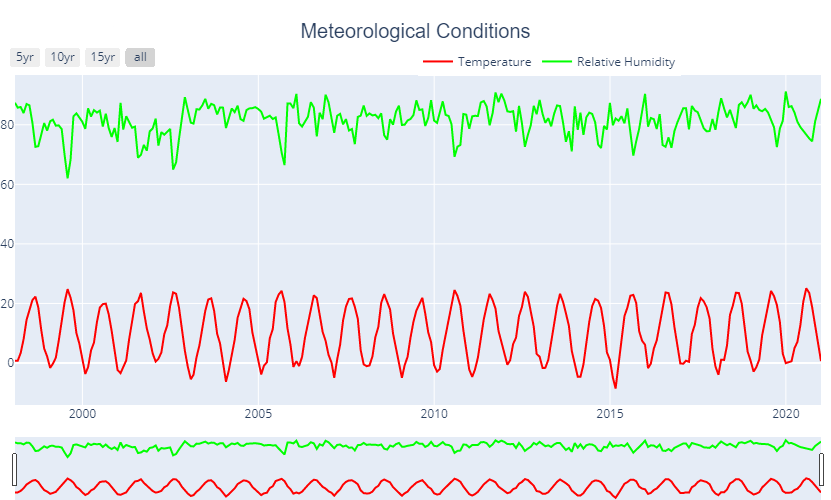

In [17]:
title = "Meteorological Conditions"
columns = ["Temperature", "Relative_Humidity", "Precipitable_Water"]
fig2 = plot_tools.plot_multi_line(df_rsm, title=title, columns=columns)

In [19]:
pass

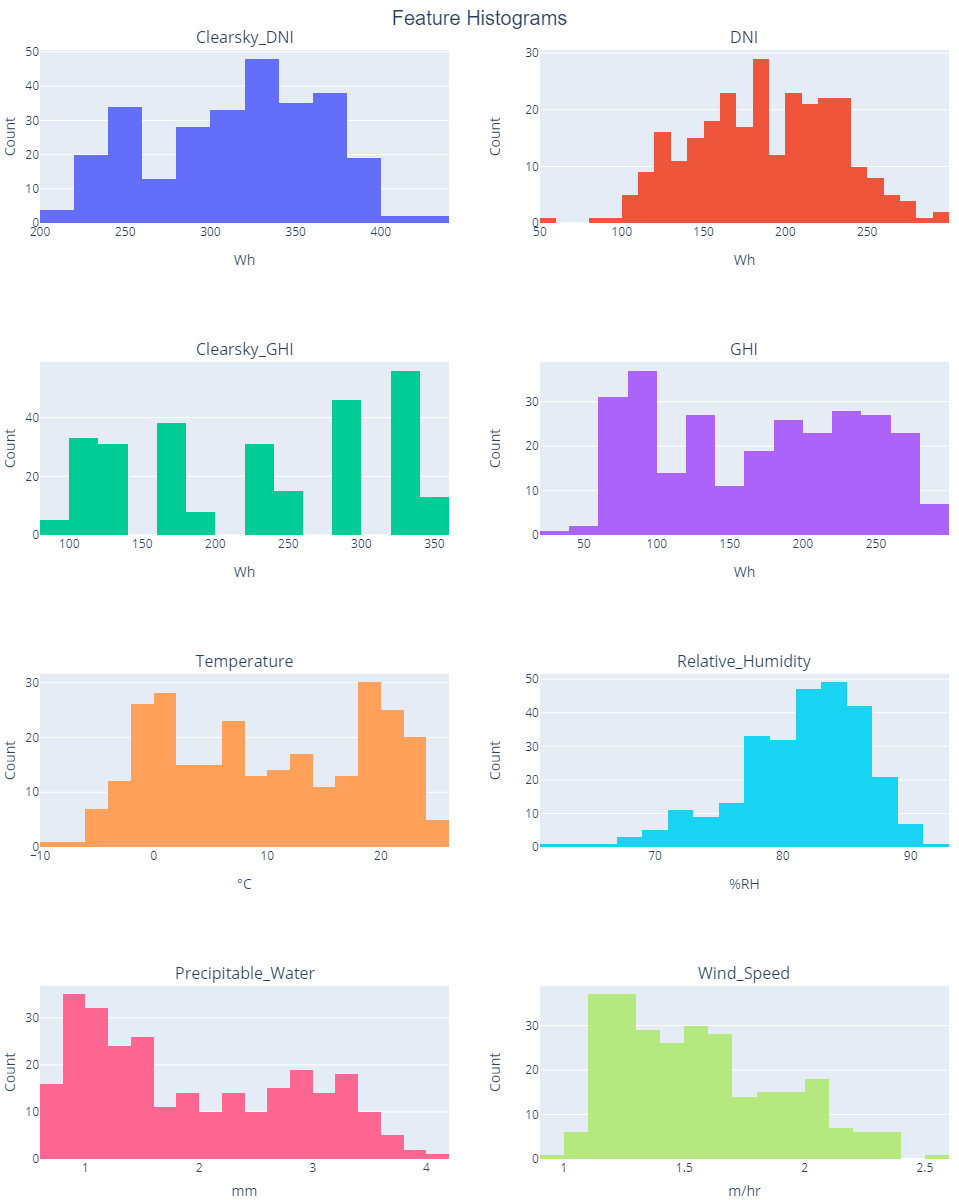

In [34]:
# begin == 0, end == None -> include all data
begin = 0  # math.ceil(len(df_rs)*.90)
end = None  # math.ceil(len(df_rs) * 0.075)

df_plot = df_rsm.iloc[begin:end]

col_idx = 0
rows, cols = 4, 2

fig = make_subplots(
    rows=rows,
    cols=cols,
    subplot_titles=columns,
)

for _, row in enumerate(range(1, rows + 1)):
    for _, col in enumerate(range(1, cols + 1)):
        fig.add_trace(
            go.Histogram(
                x=df_plot[columns[col_idx]],
                name=columns[col_idx],
                showlegend=False,
            ),
            row=row,
            col=col,
        )

        fig.update_yaxes(
            title_text="Count",
            row=row,
            col=col,
        )

        fig.update_xaxes(
            title_text=feature_units[col_idx],
            row=row,
            col=col,
        )

        col_idx += 1

fig.update_layout(
    title=dict(
        text=f"Feature Histograms",
        xanchor="center",
        x=0.5,
        font=dict(
            family="Arial",
            size=20,
        ),
    ),
    autosize=True,
    height=1200,
    margin=dict(
        l=5,
        r=5,
        b=0,
        t=50,
        pad=0,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.1,
    ),
)

fig.show()

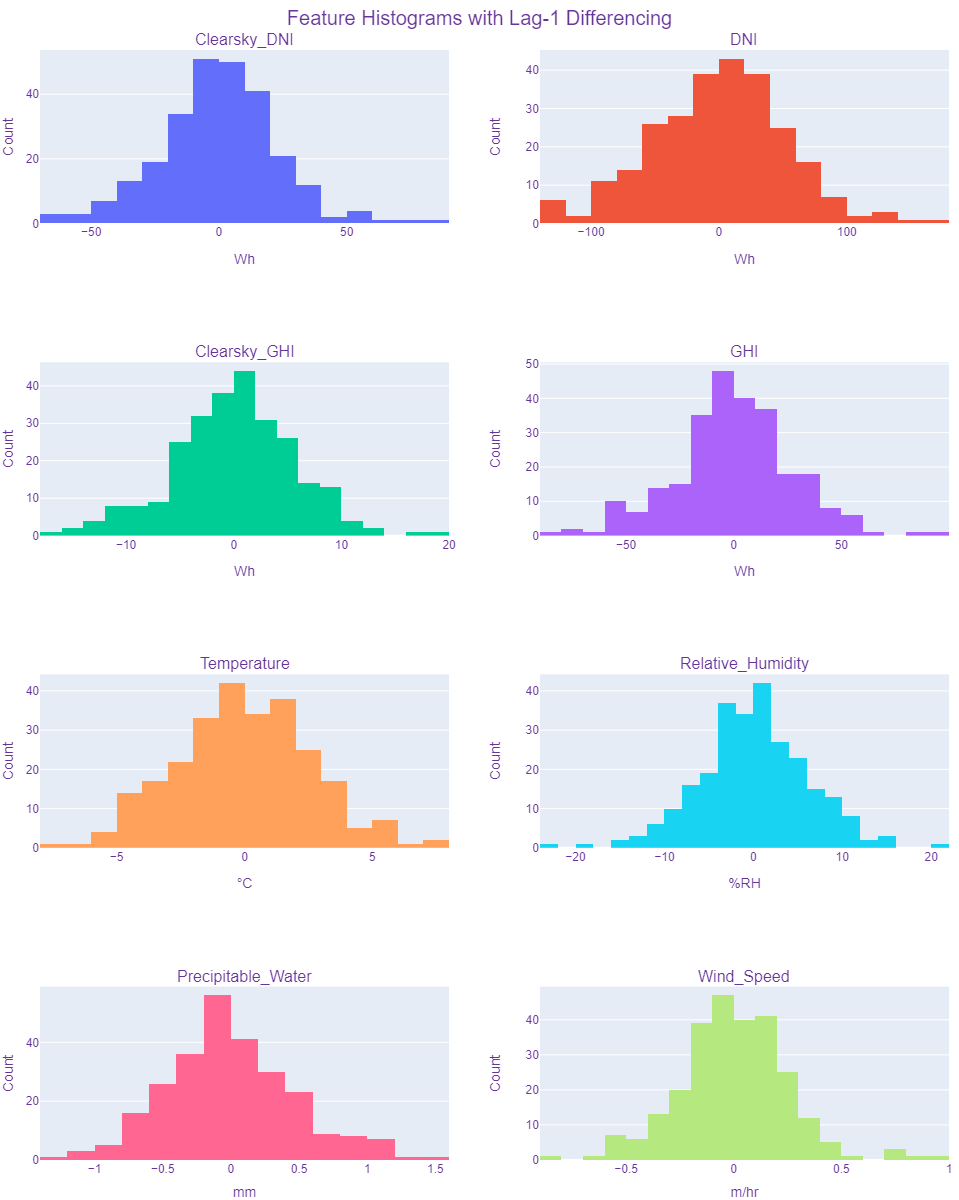

In [36]:
# begin == 0, end == None -> include all data
begin = 0  # math.ceil(len(df_rs)*.90)
end = None  # math.ceil(len(df_rs) * 0.075)


df_diff = df_rsm.iloc[begin:end].copy()

for column in columns:
    df_diff[column] = diff(df_diff[column], 1, 1, 12)

df_diff.dropna(inplace=True)

df_plot = df_diff

col_idx, rows, cols = 0, 4, 2

fig = make_subplots(
    rows=4,
    cols=2,
    subplot_titles=columns,
)

for _, row in enumerate(range(1, rows + 1)):
    for _, col in enumerate(range(1, cols + 1)):
        fig.add_trace(
            go.Histogram(
                x=df_plot[columns[col_idx]],
                name=columns[col_idx],
                showlegend=False,
            ),
            row=row,
            col=col,
        )

        fig.update_yaxes(
            title_text="Count",
            row=row,
            col=col,
        )

        fig.update_xaxes(
            title_text=feature_units[col_idx],
            row=row,
            col=col,
        )

        col_idx += 1

fig.update_layout(
    title=dict(
        text=f"Feature Histograms with Fist-Differencing",
        xanchor="center",
        x=0.5,
        font=dict(
            family="Arial",
            size=20,
        ),
    ),
    font=dict(
        family="Arial",
        size=12,
        color="RebeccaPurple",
    ),
    autosize=True,
    height=1200,
    margin=dict(
        l=5,
        r=5,
        b=0,
        t=50,
        pad=0,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.1,
    ),
)


fig.show()

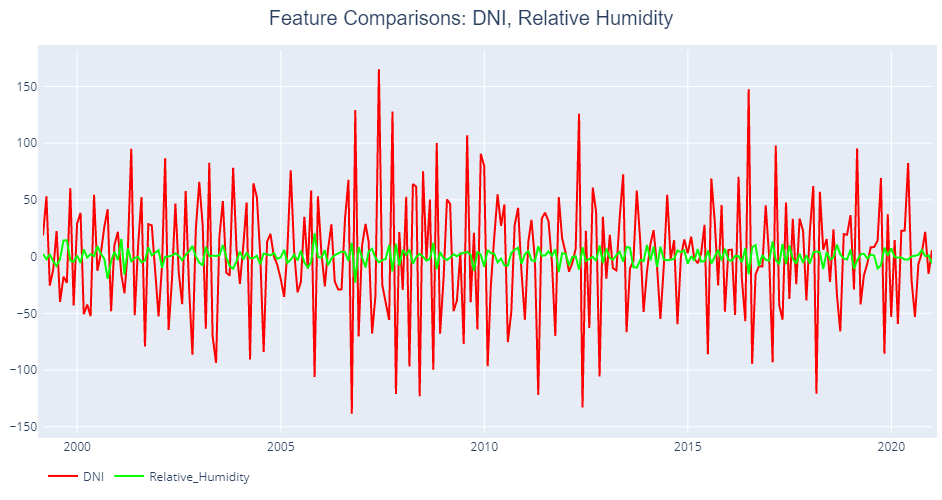

In [42]:
# begin == 0, end == None -> include all data
begin = 0  # math.ceil(len(df_rs)*.90)
end = None  # math.ceil(len(df_rs) * 0.075)

make_diff = True

if make_diff:
    df_diff = df_rsm.iloc[begin:end].copy()
    for column in columns:
        df_diff[column] = diff(df_diff[column], 1, 1, 12)
    df_diff.dropna(inplace=True)

    df_plot = df_diff
else:
    df_plot = df_rsm.iloc[begin:end]

colors = ["rgb(255,0,0)", "rgb(0,255,0)", "rgb(0,0,255)"]

# labels = ["DNI", "Clearsky_DNI"]
labels = ["DNI", "Relative_Humidity"]
# labels = ["GHI", "Clearsky_GHI"]
# labels = ["GHI", "Relative_Humidity"]

label_text = [label.replace("_", " ") for label in labels]

fig = go.Figure()

for idx, label in enumerate(labels):
    fig.add_trace(
        go.Scatter(
            x=df_plot.index,
            y=df_plot[label],
            mode="lines",
            name=labels[idx],
            line=dict(color=colors[idx], width=2),
            connectgaps=True,
        )
    )

fig.update_layout(
    title=dict(
        text=f"Feature Comparisons: {label_text[0]}, {label_text[1]}",
        xanchor="center",
        x=0.5,
        font=dict(
            family="Arial",
            size=20,
        ),
    ),
    autosize=True,
    height=500,
    margin=dict(
        l=10,
        r=10,
        b=25,
        t=50,
        pad=5,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.15,
    ),
)

fig.show()

In [23]:
adf_tests = []

for column in columns:
    adf_tests.append(adfuller(df_diff[column], autolag="AIC"))

for column, test in zip(columns, adf_tests):
    print(f"p-value: {test[1]}, lags: {test[2]} for {column}")

p-value: 1.4012603514789216e-11, lags: 15 for Clearsky_DNI
p-value: 3.979674577746029e-12, lags: 15 for DNI
p-value: 5.01140171111101e-13, lags: 16 for Clearsky_GHI
p-value: 1.4733611225851186e-10, lags: 15 for GHI
p-value: 5.5656985991352785e-09, lags: 14 for Temperature
p-value: 1.3227646323753114e-11, lags: 15 for Relative_Humidity
p-value: 1.9485501317843294e-11, lags: 16 for Precipitable_Water
p-value: 2.0413007243597271e-07, lags: 13 for Wind_Speed


In [24]:
kpss_tests = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for column in columns:
        kpss_tests.append(kpss(df_diff[column], regression="ct", nlags="auto"))

for column, test in zip(columns, kpss_tests):
    print(f"p-value: {test[1]}, {test[2]} for {column}")

p-value: 0.01, 161 for Clearsky_DNI
p-value: 0.1, 47 for DNI
p-value: 0.0640717494466728, 70 for Clearsky_GHI
p-value: 0.1, 58 for GHI
p-value: 0.1, 45 for Temperature
p-value: 0.1, 18 for Relative_Humidity
p-value: 0.08809948923166253, 67 for Precipitable_Water
p-value: 0.1, 23 for Wind_Speed
